<a href="https://colab.research.google.com/github/tamojeetroychowdhury/Facial-Expression-Recognition/blob/main/Week-1/Logistic_Regression_Gaia_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install astroquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 4.8 MB/s 
     |████████████████████████████████| 885 kB 57.5 MB/s 
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 4.0 MB 50.1 MB/s 


In [8]:
import astropy.units as u
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


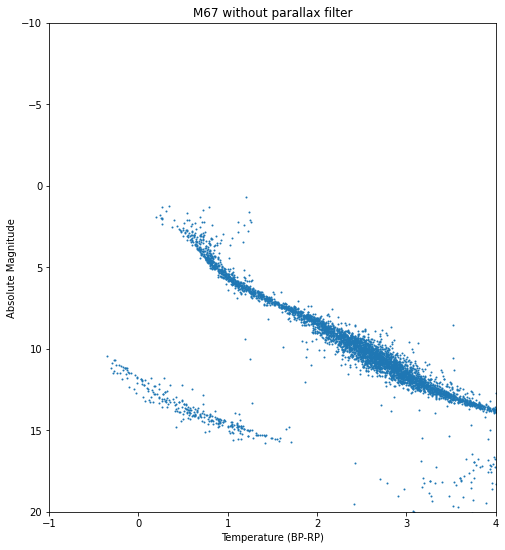

In [60]:
#Nearest 5000 stars
query = '''select top 5000 g.source_id, g.parallax, g.phot_g_mean_mag, g.phot_bp_mean_mag, phot_rp_mean_mag, 
h.classprob_dsc_combmod_star as star_prob, h.classprob_dsc_combmod_whitedwarf as wd_prob
from gaiadr3.gaia_source as g, gaiadr3.astrophysical_parameters as h 
where g.source_id = h.source_id 
and g.source_id is not null and g.parallax is not null and g.phot_g_mean_mag is not null and g.phot_bp_mean_mag is not null
and g.phot_rp_mean_mag is not null
and h.classprob_dsc_combmod_star is not null
and h.classprob_dsc_combmod_whitedwarf is not null
and g.parallax > 10
and g.parallax_over_error > 100
order by g.parallax desc'''

job = Gaia.launch_job_async(query)
r = job.get_results()

appmags = r['phot_g_mean_mag']
dist = 1000*np.reciprocal(r['parallax'])

abmags = appmags + 5 - 5*np.log10(dist)
#temps = r['teff_gspphot']
g = r['phot_bp_mean_mag'] - r['phot_rp_mean_mag']


plt.figure(figsize=(8,9))
plt.scatter(g,abmags,s=1)
plt.ylim(-10,20)
#plt.xlim(1000,30000)
plt.xlim(-1,4)
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Temperature (BP-RP)')
plt.ylabel('Absolute Magnitude')
plt.title('M67 without parallax filter')
plt.show()

In [61]:
len(r)

5000

In [69]:
X = []
y = []
for i in range(len(r)):
  X.append([abmags[i],r['phot_rp_mean_mag'][i],r['phot_bp_mean_mag'][i]])
  if r['star_prob'][i] > r['wd_prob'][i]:
    y.append(0)
  else:
    y.append(1)
X = np.array(X)
y = np.array(y)

In [70]:
X.shape

(5000, 3)

In [78]:
# 0) Prepare data

n_samples, n_features = X.shape
#n_samples, n_features = 5000,3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

# 1) Model
# Linear model f = wx + b , sigmoid at the end
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_features)

# 2) Loss and optimizer
num_epochs = 100
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 3) Training loop
for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')


with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {acc.item():.4f}')

epoch: 10, loss = 0.5803
epoch: 20, loss = 0.5641
epoch: 30, loss = 0.5487
epoch: 40, loss = 0.5340
epoch: 50, loss = 0.5200
epoch: 60, loss = 0.5067
epoch: 70, loss = 0.4940
epoch: 80, loss = 0.4819
epoch: 90, loss = 0.4704
epoch: 100, loss = 0.4593
accuracy: 0.9730


In [76]:
# 0) Prepare data

n_samples, n_features = X.shape
#n_samples, n_features = 5000,3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

# 1) Model
# Linear model f = wx + b , sigmoid at the end
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_features)

# 2) Loss and optimizer
num_epochs = 100
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 3) Training loop
for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')


with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {acc.item():.4f}')

epoch: 10, loss = 0.6885
epoch: 20, loss = 0.6613
epoch: 30, loss = 0.6359
epoch: 40, loss = 0.6122
epoch: 50, loss = 0.5902
epoch: 60, loss = 0.5697
epoch: 70, loss = 0.5506
epoch: 80, loss = 0.5328
epoch: 90, loss = 0.5163
epoch: 100, loss = 0.5008
accuracy: 0.8700
